# Sentiment Analysis

In [1]:
# import libraries
import os
import re
import nltk
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report

%matplotlib inline

2023-11-07 00:25:50.278392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# download stopwords and stemmer
nltk.download('stopwords')
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>


In [3]:
# declare constants
DATASET_FILENAME = 'training.1600000.processed.noemoticon.csv'
DATASET_COLUMNS = ['sentiment', 'id', 'timestamp', 'flag', 'user', 'text']
TEXT_PREPROCESS_RE = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 30
W2V_MIN_COUNT = 10
MAX_LENGTH = 300
POSITIVE = 'Positive'
NEGATIVE = 'Negative'
NEUTRAL = 'Neutral'
SENTIMENT_THRESHOLDS = (0.4, 0.6)
SA_MODEL = 'sa_model.keras'
TOKENIZER = 'tokenizer.pkl'
MODELS_FOLDER = 'models'

In [4]:
# dataset path
dataset_path = os.path.join('.', 'data', DATASET_FILENAME)
dataset_path

'./data/training.1600000.processed.noemoticon.csv'

## Data Ingestion

In [5]:
# read dataset
df = pd.read_csv(dataset_path, encoding='ISO-8859-1', names=DATASET_COLUMNS)
df.head()

,sentiment,id,timestamp,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
# print shape
df.shape

(1600000, 6)

In [7]:
# print info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   timestamp  1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
# Check for nulls
df.isna().sum()

sentiment    0
id           0
timestamp    0
flag         0
user         0
text         0
dtype: int64

In [9]:
# print unique values of sentiment column
df['sentiment'].unique()

array([0, 4])

In [10]:
# target is balanced
df['sentiment'].value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

<Axes: xlabel='sentiment'>

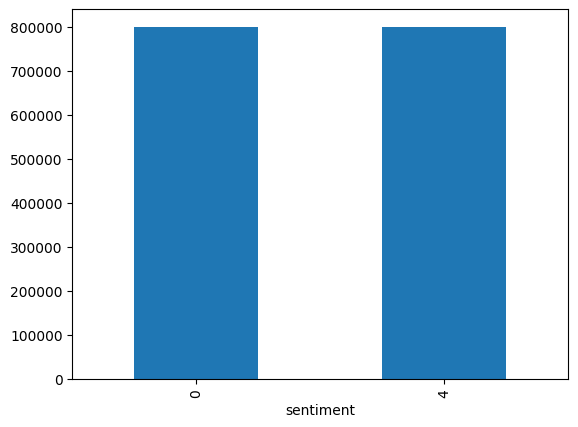

In [11]:
# plot sentiment
df['sentiment'].value_counts().plot(kind='bar')

## Data Preprocessing

Convert Sentiment to String
* 0 - Negative
* 2 - Neutral
* 4 - Positive

In [12]:
# map sentiment integer to string
sentiment_map = {
                0: 'Negative', 
                2: 'Neutral', 
                4: 'Positive'
            }

In [13]:
# convert sentiment to string
df['sentiment'] = df['sentiment'].apply(lambda x: sentiment_map[int(x)])
df.sample(5)

,sentiment,id,timestamp,flag,user,text
722852,Negative,2261616469,Sat Jun 20 21:04:14 PDT 2009,NO_QUERY,morrisjo,done for the night as I feel i have a cold
187350,Negative,1968628937,Fri May 29 21:51:05 PDT 2009,NO_QUERY,Cherise_Nicole,@shesillmatic me too
1346961,Positive,2044429257,Fri Jun 05 09:20:44 PDT 2009,NO_QUERY,sharonxo,@sprklsyndrm watching spongebob while eating s...
1544433,Positive,2181777111,Mon Jun 15 12:16:56 PDT 2009,NO_QUERY,THeffer,watching the first couple of eps of season 2 o...
593630,Negative,2218289578,Wed Jun 17 22:12:49 PDT 2009,NO_QUERY,j006t,Damn! I've got to go to schoool!!


In [14]:
# function to preprocess the text
def preprocess_text(text, stem=False):
    # exclude hyperlinks, usernames and special characters
    text = re.sub(TEXT_PREPROCESS_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

In [15]:
# clean the text for model training
df['clean_text'] = df['text'].apply(lambda text: preprocess_text(text))
df.head()

,sentiment,id,timestamp,flag,user,text,clean_text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behaving mad see


### Split the dataset

In [16]:
# create X and y
X = df['clean_text']
y = df['sentiment']

In [17]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1120000,), (480000,), (1120000,), (480000,))

### Generate Word Embeddings using Word2Vec

`word2vec is an algorithm to train word embeddings: given a raw text, it calculates a word vector for every word in the vocabulary. These vectors can be used in other applications, thus they form a pretrained model.`

In [18]:
# split text into tokens
train_documents = [text.split() for text in X_train]
len(train_documents)

1120000

In [19]:
# initialize word2vec
w2v_model = Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT)

In [20]:
# build vocabulary
w2v_model.build_vocab(train_documents)

In [21]:
# train the word2vec model
w2v_model.train(train_documents, total_examples=len(train_documents), epochs=W2V_EPOCH)

(215297858, 242318700)

### Tokenize the Text

In [22]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print('Total Words in Vocabulary', vocab_size)

Total Words in Vocabulary 266578


In [23]:
# pad sequences
X_train_ps = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LENGTH)
X_test_ps = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LENGTH)

In [24]:
# encode the sentiments
sentiments = df['sentiment'].unique().tolist()
sentiments.append('Neutral')
sentiments

['Negative', 'Positive', 'Neutral']

In [25]:
# perform label encoding
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_le = encoder.transform(y_train)
y_test_le = encoder.transform(y_test)

y_train_le = y_train_le.reshape(-1, 1)
y_test_le = y_test_le.reshape(-1, 1)

print('y_train_le', y_train_le.shape)
print('y_test_le', y_test_le.shape)

y_train_le (1120000, 1)
y_test_le (480000, 1)


In [26]:
# print shapes
X_train_ps.shape, y_train_le.shape, X_test_ps.shape, y_test_le.shape

((1120000, 300), (1120000, 1), (480000, 300), (480000, 1))

## Build and Train the Model

In [27]:
# generate embedding matrix
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(266578, 300)


In [28]:
# build the model
sa_model = Sequential()
sa_model.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))
sa_model.add(Dropout(0.5))
sa_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
sa_model.add(Dense(1, activation='sigmoid'))

In [29]:
# print model summary
sa_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          79973400  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 80133901 (305.69 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 79973400 (305.07 MB)
_________________________________________________________________


In [30]:
# compile the model
sa_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# initialize call backs
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [32]:
%%time
# train the model
history = sa_model.fit(X_train_ps, 
                    y_train_le,
                    batch_size=1024,
                    epochs=3,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/3
875/875 [==============================] - 6503s 7s/step - loss: 0.5081 - accuracy: 0.7476 - val_loss: 0.4687 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 2/3
875/875 [==============================] - 6433s 7s/step - loss: 0.4824 - accuracy: 0.7655 - val_loss: 0.4611 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 3/3
875/875 [==============================] - 6484s 7s/step - loss: 0.4744 - accuracy: 0.7702 - val_loss: 0.4564 - val_accuracy: 0.7839 - lr: 0.0010
CPU times: user 1d 3h 15min 32s, sys: 22h 31min 4s, total: 2d 1h 46min 36s
Wall time: 5h 23min 41s


## Model Evaluation

In [33]:
# evaluate the model
score = sa_model.evaluate(X_test_ps, y_test_le)
print('Accuracy: ', score[1])
print('Loss: ', score[0])

15000/15000 [==============================] - 2019s 135ms/step - loss: 0.4558 - accuracy: 0.7846
Accuracy:  0.7845645546913147
Loss:  0.45578262209892273


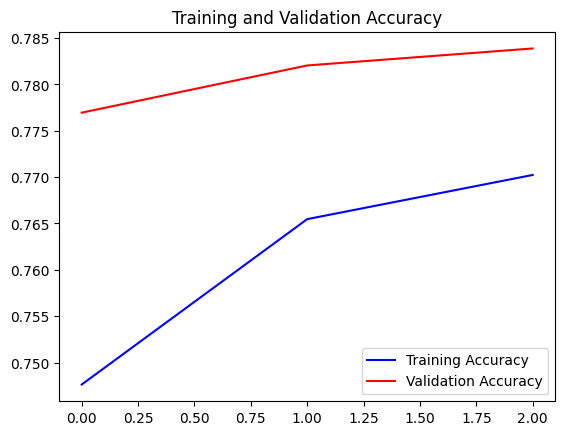

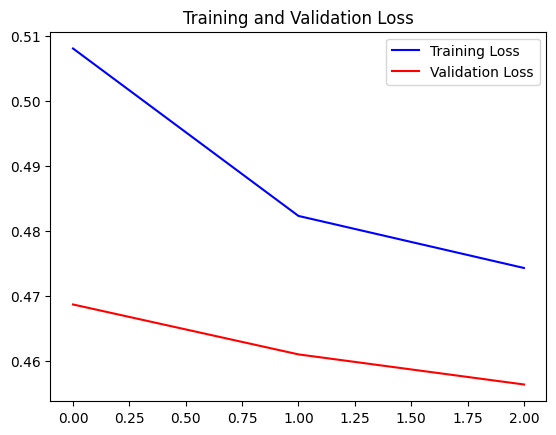

In [34]:
# visualize the metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
 
plt.show()

## Model Prediction

In [35]:
# function to generate sentiment from score
def generate_sentiment(score):
    sentiment = NEUTRAL
    if score <= SENTIMENT_THRESHOLDS[0]:
        sentiment = NEGATIVE
    elif score >= SENTIMENT_THRESHOLDS[1]:
        sentiment = POSITIVE
    return sentiment

In [36]:
# model prediction
y_pred_1d = []
y_test_1d = list(y_test_le)
scores = sa_model.predict(X_test_ps, verbose=1)
y_pred_1d = [0 if score < 0.5 else 1 for score in scores]

15000/15000 [==============================] - 1636s 109ms/step


In [37]:
# print classification report
pd.DataFrame(classification_report(y_test_1d, y_pred_1d, output_dict=True)).T

,precision,recall,f1-score,support
0,0.799834,0.757567,0.778127,239361.000000
1,0.770897,0.811419,0.790639,240639.000000
accuracy,0.784565,0.784565,0.784565,0.784565
macro avg,0.785366,0.784493,0.784383,480000.000000
weighted avg,0.785327,0.784565,0.784400,480000.000000


In [38]:
# function to predict sentiment from text
def predict_sentiment(text):
    # tokenize text
    padded_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_LENGTH)
    # generate prediction
    score = sa_model.predict([padded_text])[0]
    # compute sentiment
    sentiment = generate_sentiment(score)

    return {'sentiment': sentiment, 'score': float(score[0])}  

In [39]:
predict_sentiment("DigitalOcean is a powerful tool so as to control the virtual server in the cloud. It's widely used in our organization so that the servers can be allocated in multiple regions as per our needs. It's a highly scalable and flexible tool to host websites and web apps that allows us to use our own servers as well. The performance is great and the server cost is inexpensive. The user can eventually have full control over the machine with its user friendly interface.")

1/1 [==============================] - 0s 482ms/step


{'sentiment': 'Positive', 'score': 0.7434084415435791}

In [40]:
predict_sentiment("I have used Digital Ocean for more than 2 years and I regret it. I started over the recommendation of our freelancer, but in 2 years, I always had a hard time, from setting up, to managing, to backup, and performance, everything was very hard and confusing for me. And whenever I had a problem and opened a ticket, I only received automated responses and never heard from a real person answering my messages! In the end, one of my sites was hacked because of Digital Ocean and they didn't even bother to respond to me for anything at all! I finally pulled the plug and changed to another hosting provider which I am happy with! So, in short, if you are not a genius with IT, stay away from Digital Ocean. Or if you use, pray that you will not have any problems and will need technical support, because if you do, support will be nowhere to be found! Stay away at all costs! You will regret it!")

1/1 [==============================] - 0s 61ms/step


{'sentiment': 'Negative', 'score': 0.189682736992836}

In [41]:
predict_sentiment("DigitalOcean is either too good or bad to comment. It is just another cloud platform.")

1/1 [==============================] - 0s 61ms/step


{'sentiment': 'Neutral', 'score': 0.5290109515190125}

## Save the Models

In [42]:
# saved models path
models_path = os.path.join(MODELS_FOLDER + '/')
models_path

'models/'

In [43]:
# save models
sa_model.save(models_path + SA_MODEL)
pickle.dump(tokenizer, open(models_path + TOKENIZER, 'wb'))

## Load Saved Models

In [44]:
# load sentiment analysis model
loaded_sa_model = tf.keras.models.load_model(models_path + SA_MODEL)
loaded_sa_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          79973400  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 80133901 (305.69 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 79973400 (305.07 MB)
_________________________________________________________________


In [45]:
# load tokenizer
loaded_tokenizer_model = pickle.load(open(models_path + TOKENIZER, 'rb'))

## Predict from Loaded Models 

In [48]:
# function to predict sentiment from loaded models
def infer_sentiment(text):
    # preprocess text
    text = preprocess_text(text)
    # tokenize text
    padded_text = pad_sequences(loaded_tokenizer_model.texts_to_sequences([text]), maxlen=MAX_LENGTH)
    # generate prediction
    score = loaded_sa_model.predict([padded_text])[0]
    # compute sentiment
    sentiment = generate_sentiment(score)

    return {'sentiment': sentiment, 'score': float(score[0])}  

In [49]:
infer_sentiment("DigitalOcean is a powerful tool so as to control the virtual server in the cloud. It's widely used in our organization so that the servers can be allocated in multiple regions as per our needs. It's a highly scalable and flexible tool to host websites and web apps that allows us to use our own servers as well. The performance is great and the server cost is inexpensive. The user can eventually have full control over the machine with its user friendly interface.")

1/1 [==============================] - 0s 302ms/step


{'sentiment': 'Positive', 'score': 0.7434084415435791}